# resnet18 model and ipex optimization

## importing the required libraries

In [1]:
import torch
import torchvision.datasets as ds
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.transforms as tr
import torchvision.models as md
import  torch.optim as optim
from torch.utils.data import random_split
import intel_extension_for_pytorch as ipex
import numpy 
from torchvision import transforms
from PIL import Image

/opt/intel/inteloneapi/pytorch/latest/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /glob/development-tools/versions/oneapi/2023.1.2/oneapi/pytorch/1.13.10.2/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


## downloading the data

In [2]:

fashion_mnist = ds.FashionMNIST(download=False, train=True, root="fashion_mnist_data").train_data.float()
data_transform = transforms.Compose([ transforms.Resize((28, 28)),

                                     
                                         transforms.ToTensor(),
                                         transforms.Normalize((fashion_mnist.mean()/255,), (fashion_mnist.std()/255,))])

trainset = ds.FashionMNIST(root='fashion_mnist_data',
                                      train=True,
                                      download=True,
                                      transform=data_transform,
                          )

valset =  ds.FashionMNIST(root='fashion_mnist_data',
                                      train=True,
                                      download=True,
                                      transform=data_transform,
                          )

testset = ds.FashionMNIST(root='fashion_mnist_data',
                                     train=False,
                                     download=True,
                                     transform=data_transform
                                    )

/opt/intel/inteloneapi/pytorch/latest/lib/python3.9/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


## split the training data into training, validation and tresting sets

In [3]:
train_set, val_set= torch.utils.data.random_split(trainset, [50000, 10000])


## visualizing an image in the given data

label:  0
torch.Size([1, 28, 28])


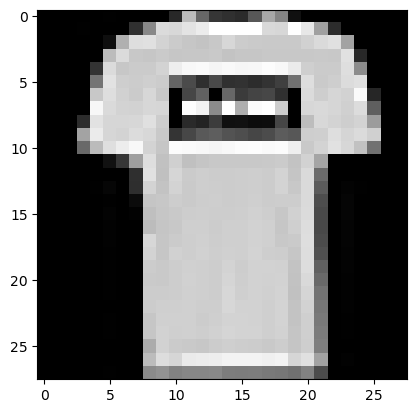

In [27]:
import matplotlib.pyplot as plt

# plot images
image , label = trainset[1]
labels = str(label)
plt.imshow(image.reshape(28,28), cmap = 'gray')
print('label: ',label)
print(image.shape)

## loading the data using dataloader with batchsize as 128

In [5]:
batchsize=128
traindlr = DataLoader(train_set,batchsize,shuffle =True)
valdlr = DataLoader(val_set,batchsize,shuffle =False)
testdlr = DataLoader(testset,batchsize,shuffle =False)

## displaying the first 36 images in the train set along with its labels

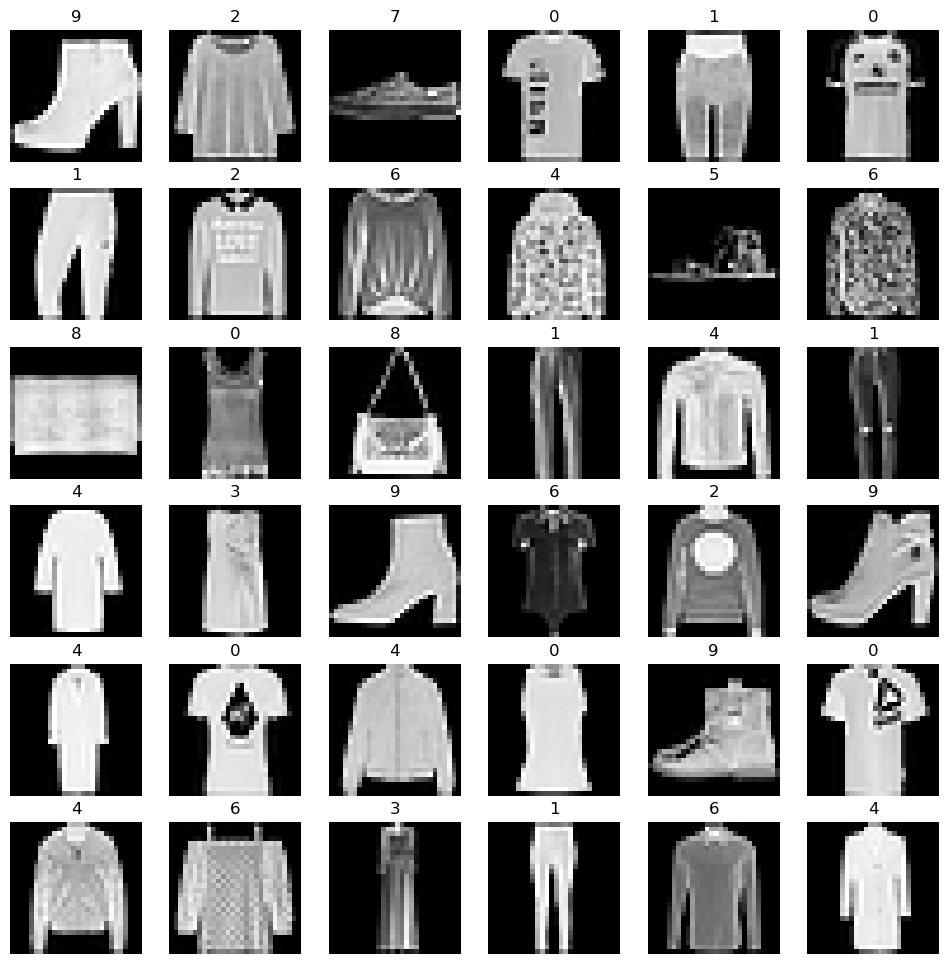

In [6]:

plt.figure(figsize=(12,12))
plt.subplot(321)
for i in range(36):
    ax1 = plt.subplot(6,6,i+1)
    images , labels = train_set[i]
    plt.imshow(images.reshape(28,28).detach().numpy(),cmap='gray')
    plt.title(labels)
    plt.axis('off')
plt.show()

## Create a resnet18 model

In [12]:
class resmnist(nn.Module):
    def __init__(self,in_chan=1):
        super(resmnist,self).__init__()
        self.model = md.resnet18(pretrained = True) # prebuillt resent 18 model
        self.model.conv1 = nn.Conv2d(in_chan, 64,kernel_size=7, stride=2, padding=3, bias=False)
        self.model.bn1 = nn.BatchNorm2d(64)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 10)
        self.model.drop = nn.Dropout2d(0.4) #droput function
        
        
        
    def forward(self, x):
        return self.model(x)


my_resnet = resmnist()

## implementing cross entropy loss function and adam optimizer

In [13]:
net = resmnist().to('cpu')           # Creating object for LeNet() model and passing it to CPU  
loss_fn = nn.CrossEntropyLoss()    # It takes the highest value which is the predictions and mark it as 1                                # And mark rest of the values as zeros. 
opt = optim.Adam(net.parameters(),lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.01, patience=3)


In [14]:
net.eval()

resmnist(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

## function to find the accuracy of train set and val set

In [15]:
def evaluation(DataLoader):
    total , correct = 0,0
    for data in DataLoader:
        inputs , labels = data
        inputs = inputs.to('cpu') 
        labels = labels.to('cpu')
        output = net(inputs)            
        max_pred,pred = torch.max(output.data,dim=1)
        total +=labels.size(0)
        correct = correct + ((pred == labels).sum().item())  
    return 100 * correct / total 

## training and validating the model with 25 epochs 

In [16]:
loss_arr = []
loss_epoch_arr = []
val_loss_arr = []
acc_arr=[]
val_acc_arr=[]
def fit(max_epochs):
    batches = len(traindlr)
    val_batches = len(valdlr)
    for epoch in range(max_epochs):
        total_loss= 0 
        net.train()
        for i, data in enumerate(traindlr): # Iterating through the train loader 
            inputs,labels = data
            inputs,labels = inputs.to('cpu'),labels.to('cpu')


            opt.zero_grad()     # Reset the gradient in every iteration
            outputs = net(inputs)
            loss = loss_fn(outputs,labels)   # Loss forward pass
            loss.backward()# Loss backaed pass
            
            opt.step()# Update all the parameters by the given learnig rule
            total_loss += loss.item()
        loss_arr.append(total_loss)
        val_loss=0
        net.eval()
        with torch.no_grad():
            for i, data in enumerate(valdlr): # Iterating through the val loader 
                inputs,labels = data
                inputs,labels = inputs.to('cpu'),labels.to('cpu')

                outputs = net(inputs)
                val_loss += loss_fn(outputs,labels).item()   # Loss forward pass
        val_loss_arr.append(val_loss)
        scheduler.step(evaluation(valdlr))
        
        print('Val accuracy: %0.2f , Train accuracy : %0.2f'%(evaluation(valdlr),evaluation(traindlr)))
        acc_arr.append(evaluation(traindlr))
        val_acc_arr.append(evaluation(valdlr))
        print('Val loss:'+ str(val_loss/val_batches) +' Train loss'+ str(total_loss/batches))
        
max_epochs = 25



fit(max_epochs)
torch.save(net, 'resnet18.pt') 

Val accuracy: 87.02 , Train accuracy : 87.80
Val loss:0.36366030762467205 Train loss0.48832019203154325
Val accuracy: 88.06 , Train accuracy : 89.59
Val loss:0.32561025136633764 Train loss0.32946838720527755
Val accuracy: 88.03 , Train accuracy : 89.81
Val loss:0.3217416111427017 Train loss0.28621009262778874
Val accuracy: 89.27 , Train accuracy : 91.84
Val loss:0.2902210747139363 Train loss0.25991016243348647
Val accuracy: 89.62 , Train accuracy : 92.28
Val loss:0.29393222475353675 Train loss0.2325550029078103
Val accuracy: 88.78 , Train accuracy : 91.73
Val loss:0.3077211257400392 Train loss0.2222730904207815
Val accuracy: 90.82 , Train accuracy : 94.68
Val loss:0.2519101715540584 Train loss0.20408469937798923
Val accuracy: 90.41 , Train accuracy : 94.64
Val loss:0.2637154089310501 Train loss0.18783667576892296
Val accuracy: 90.73 , Train accuracy : 94.84
Val loss:0.2692735557314716 Train loss0.17379630014033573
Val accuracy: 90.26 , Train accuracy : 94.99
Val loss:0.2808616672512851

## using intel_extension_for_pytorch(ipex) to optimize the code 

### method 1

before optimization: 15.081090927124023
after optimization: 10.52943229675293


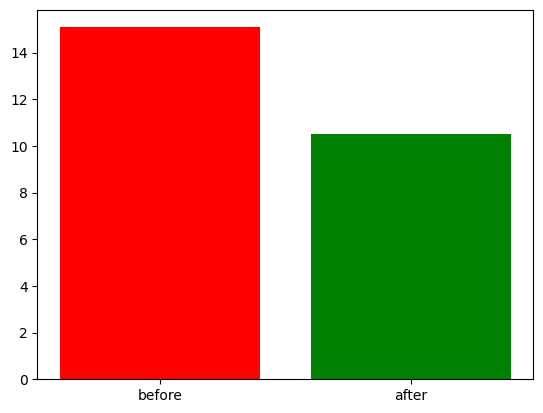

In [17]:
import time
import intel_extension_for_pytorch as ipex
for i, data in enumerate(traindlr): # Iterating through the train loader 
    inputs1,labels = data
    inputs1,labels = inputs1.to('cpu'),labels.to('cpu')

def measure_latency(input1):

    with torch.no_grad():
        for i in range(25):
            net(inputs1)
        start_time = time.time()
        for i in range(25):
            net(inputs1)
        end_time = time.time()
    n = 1000*(end_time - start_time)/25
    print('before optimization: ' + str(n))
    
    net.eval()
    imodel = ipex.optimize(net)
    with torch.no_grad():
        d = torch.rand(64,1,7,7)
        jit_model = torch.jit.trace(imodel,d)
        jit_model = torch.jit.freeze(jit_model)
    with torch.no_grad():
        for i in range(25):
            jit_model(inputs1)
        start_time = time.time()
        for i in range(25):
            jit_model(inputs1)
        end_time = time.time()
    n1 = 1000*(end_time - start_time)/25
    print('after optimization: ' + str(n1))
    plt.bar(['before','after'], [n,n1],color=['r','g'])
measure_latency(inputs1)

net.eval()
imodel = ipex.optimize(net)
with torch.no_grad():
    d = torch.rand(64,1,7,7)
    jit_model = torch.jit.trace(imodel,d)
    jit_model = torch.jit.freeze(jit_model)




### method 2

In [18]:
%%timeit
net(inputs1)

19.3 ms ± 4.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%%timeit
with torch.no_grad():
    jit_model(inputs1)

9.76 ms ± 45.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## plotting

In [20]:
import matplotlib.pyplot
a=[]
b=1
for i in range (1,max_epochs+1):
    a.append(b)
    b += 1
    

### plotting for train-loss, validation-loss vs no-of-epochs

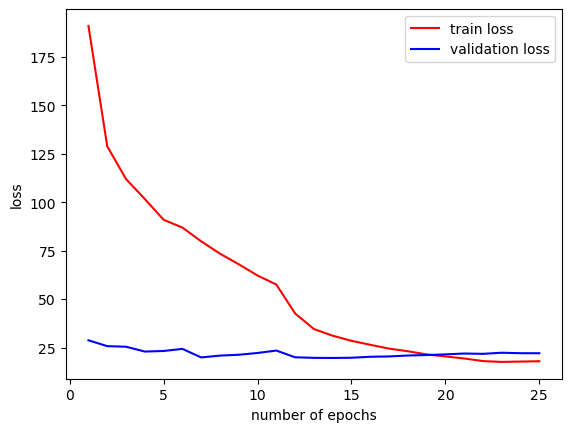

In [21]:
plt.plot(a,loss_arr,c='r',label='train loss')
plt.plot(a,val_loss_arr,c='b',label='validation loss')
plt.ylabel('loss')
plt.xlabel('number of epochs')
plt.legend()

### plotting for train-accuracy, validation-accuracy vs no-of-epochs

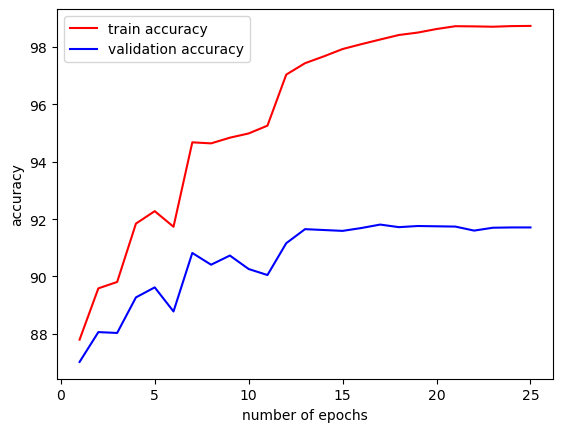

In [22]:
plt.plot(a,acc_arr,c='r',label = 'train accuracy')
plt.plot(a,val_acc_arr,c='b',label = 'validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('number of epochs')
plt.legend()

## check the inference of ipex optimized model

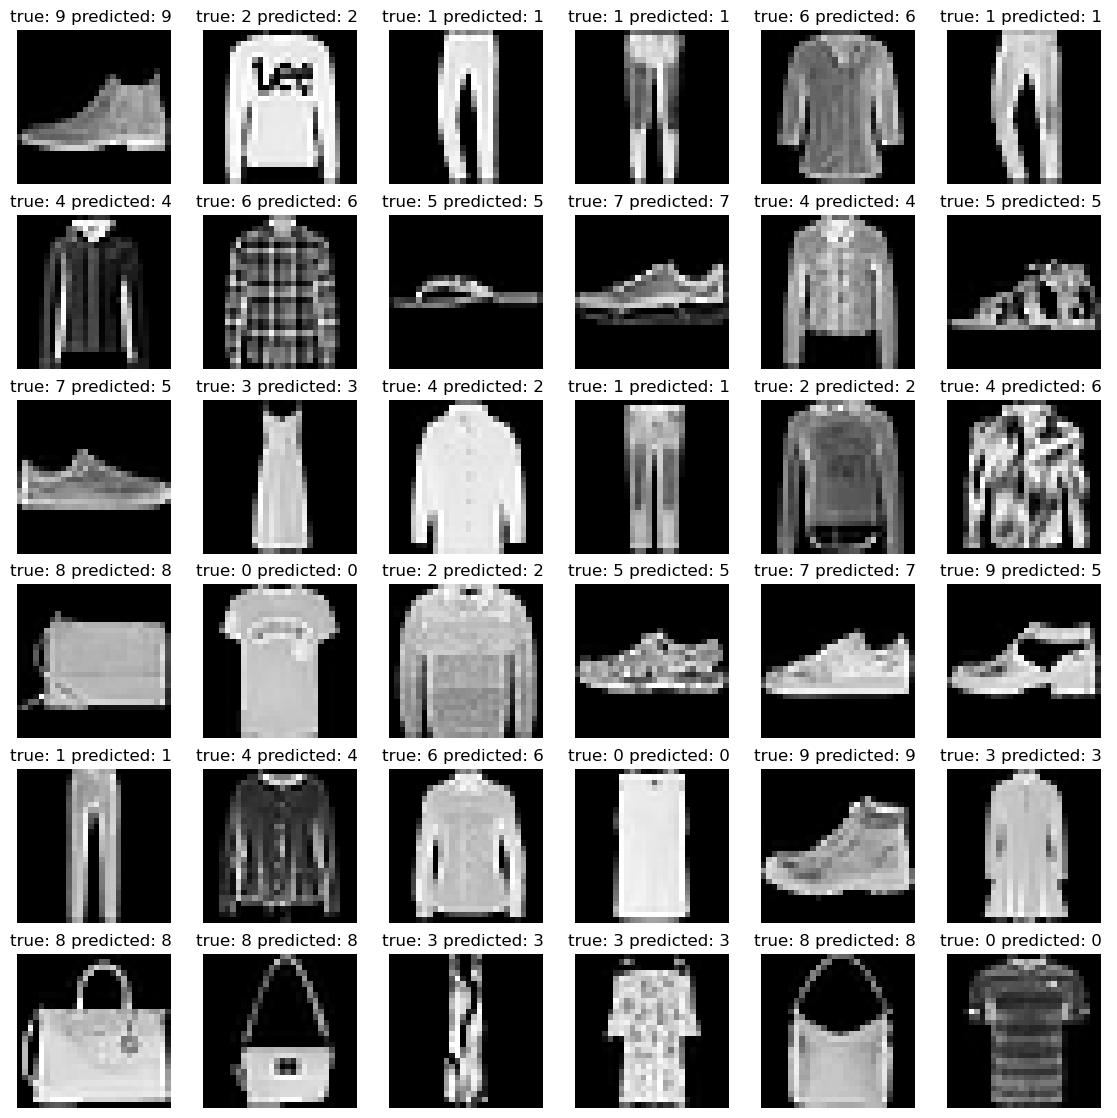

correct:  9195
total:  10000
accuracy 91.95 %


In [23]:
total=0
correct = 0
for i, data in enumerate(testdlr):
    inputs,labels = data
    inputs,labels = inputs.to('cpu'),labels.to('cpu')
    total += labels.size(0)
    with torch.no_grad():
        op = jit_model(inputs)
    max_pred,pred=torch.max(op,1)
    correct = correct +((pred == labels).sum().item())
    if i==0:
        prediction_list = pred.tolist()
        label_list = labels.tolist()

    if i !=0:
        prediction_list += pred.tolist()
        label_list += labels.tolist()


plt.figure(figsize=(14,14))
plt.subplot(321)
for i in range(36):

        ax2 = plt.subplot(6,6,i+1)
        inputs , labels = testset[i]
        ax2.imshow(inputs.reshape(28,28).detach().numpy(),cmap='gray')
        ax2.set_title("true: {} predicted: {} " .format(str(labels), str(prediction_list[i])))
        ax2.axis('off')
        
plt.show()

print('correct: ',correct)
print('total: ',total)
print('accuracy', 100* correct/total, '%')

## displaying the confusion matrix

In [24]:
from sklearn.metrics import confusion_matrix
print('actual vertical')
print('predicted horizontal')

print([' 0','1',' 2',' 3',' 4',' 5',' 6',' 7',' 8',' 9'])
print(confusion_matrix(label_list,prediction_list))

actual vertical
predicted horizontal
[' 0', '1', ' 2', ' 3', ' 4', ' 5', ' 6', ' 7', ' 8', ' 9']
[[872   1  18  15   2   1  86   0   5   0]
 [  1 983   0  11   1   0   2   0   2   0]
 [ 20   1 885   7  43   0  43   0   1   0]
 [ 13   3  11 934  19   0  19   0   1   0]
 [  1   1  62  20 869   0  46   0   1   0]
 [  0   0   0   0   0 977   0  14   1   8]
 [ 96   1  61  18  64   0 756   0   4   0]
 [  0   0   0   0   0  10   0 971   0  19]
 [  7   1   2   1   1   1   1   1 984   1]
 [  0   0   0   0   0   4   1  31   0 964]]


## visualizing the confusion matrix using sns.heatmap

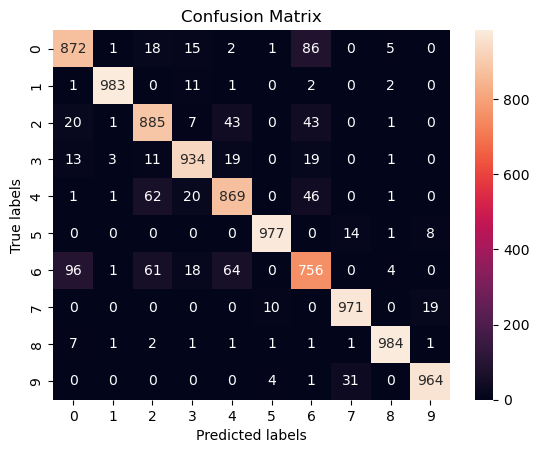

In [25]:
import seaborn as sns
ax=plt.subplot()
sns.heatmap(confusion_matrix(label_list,prediction_list),annot=True,fmt='g')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([0,1,2,3,4,5,6,7,8,9]); ax.yaxis.set_ticklabels([0,1,2,3,4,5,6,7,8,9]);